# Methylation and Deamination Estimators Simulation Comparison

Author: lee.carlin@mail.huji.ac.il  
Date: 2020-04-18  
Last edited: 2020-04-22 

To Do :  
* Find second derivative --> DONE
* Add variance simulations  - comparing the simple model to full  --> Done
* Compare my model to Liran's using complex data  
* Is Liran's model using complex data has a bias?   

Table of Contents:  

* [Simple Binomial Model (Liran's Model)](#A-Simple-Binomial-Model)  
* [Full Position Dependent Binomial Model](#Full-Position-Dependent-Binomial-Model)  

In [1]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time
import statistics


# A Simple Binomial Model  

Liran models the $t_i$ as a Binomial with parameter $n_i$ and $\pi m_i$:


* $n_i$ is the total coverage at position $i$  
* $t_i, c_i$ are the total numbers of observed T and C bases at $i$ , respectively.   
* $n_i=t_i+c_i$  
* $m_i$ is the methylation level at position $i$, $0<=m_i<=1$  
* $\pi$ is the average deamination rate over all reads.   

$t_i$ is generated according to the following binomial process:    
$t_i \sim Bin(n_i,\pi m_i)$   

The ML:  
$L(\pi m_i|n_i,t_i) = \binom{n_i}{t_i} (\pi m_i)^{t_i}(1-\pi m_i)^{n_i-t_i}$m

The MLE:  
$\hat{\pi m_i}  = \frac{t_i}{n_i}$

SOC:


SOC = $ -\frac{t_i}{m_i^2} - \frac{(n_i-t_i)*\pi^2}{(1-\pi*m_i)^2}$

$var(\theta) = [I(\theta)]^{-1} = (-E[H(\theta)])^{-1}=(-E[SOC])^{-1}$

### Simulation:

In [2]:
# Second Order Condition:
def SOC_binom(ti,pi, m_i, n_i):
    return -(t_i/(m_i**2)).sum()-(((n_i-t_i)*(pi**2))/(1-pi*m_i)**2).sum()

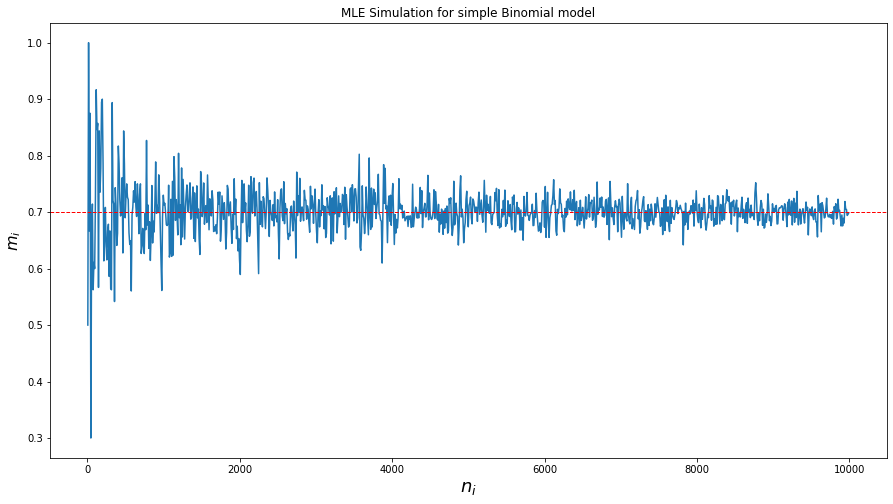

In [3]:
# Setting parameters 
max_n_i = 10000
m_i = 0.7
pi = 0.2
n_i = 30
# Sampling datapoints:
est_list = []
sd_list = []
rng = range(10,max_n_i,10)
for i in rng:
    # USING BINOMIAL MLE:
    t_i = np.random.binomial(1,pi*m_i,i)
    est_list.append(t_i.sum()/(i*pi))
    sd_list.append(1/(-SOC_binom(t_i,pi, m_i, i)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,)
#ax.errorbar(list(rng), est_list, sd_list, linestyle='-', marker='.',capsize=5,ecolor = 'red',elinewidth = 0.5,capthick = 1,lw=1)
ax.axhline(y=m_i, color = 'red', ls='--',lw=1)
ax.set_title('MLE Simulation for simple Binomial model')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
#plt.ylim([0,2])
plt.show()

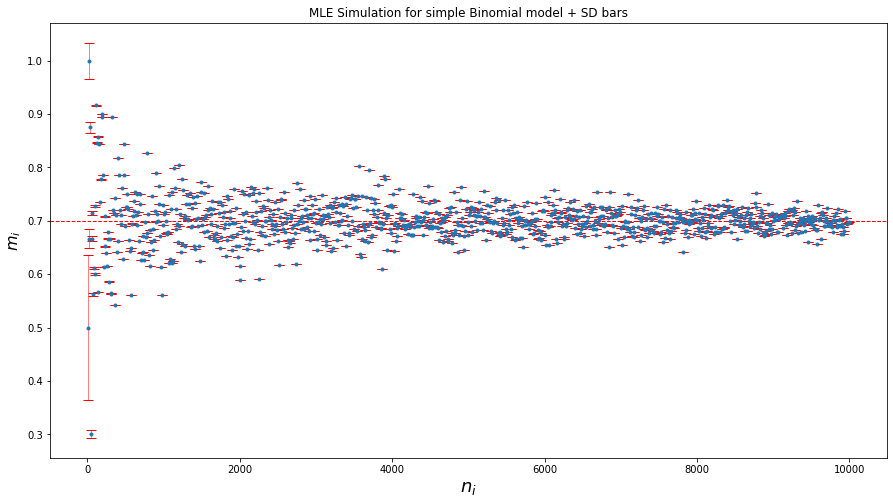

In [4]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
#ax.plot(list(rng),est_list,)
ax.errorbar(list(rng), est_list, sd_list, linestyle='', marker='.',capsize=5,ecolor = 'red',elinewidth = 0.5,capthick = 1,lw=1)
ax.axhline(y=m_i, color = 'red', ls='--',lw=1)
ax.set_title('MLE Simulation for simple Binomial model + SD bars')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
#plt.ylim([0,2])
plt.show()

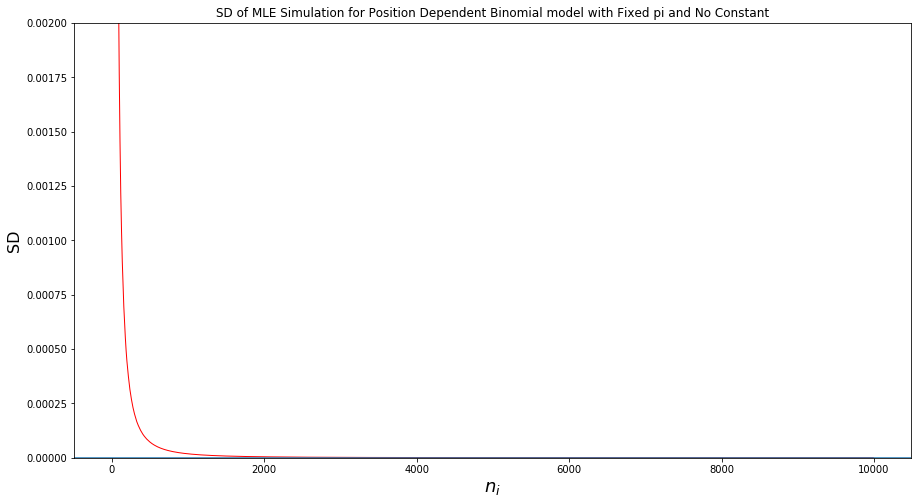

In [5]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),sd_list,lw=1,color='red')
ax.set_title('SD of MLE Simulation for Position Dependent Binomial model with Fixed pi and No Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('SD', fontsize=16)
plt.ylim([0,0.002])
ax.axhline()
plt.show()


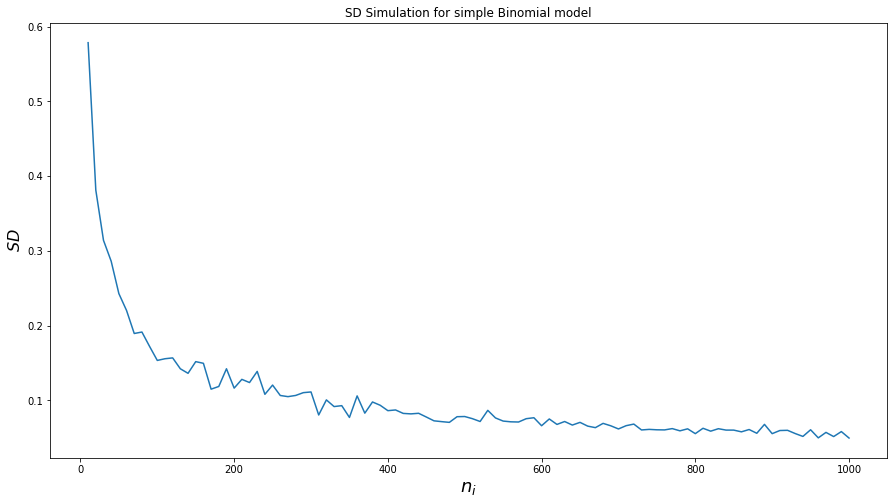

In [6]:
# Setting parameters 
max_n_i = 1000
sims = 100
m_i = 0.7
pi = 0.2
n_i = 30
# Sampling datapoints:
sd_emp_list = []
rng = range(10,max_n_i+10,10)
for i in rng:
    est_list =[]
    for k in range(1,sims+1):
        # USING BINOMIAL MLE:
        t_i = np.random.binomial(1,pi*m_i,i)
        est_list.append(t_i.sum()/(i*pi))
    
    sd_emp_list.append(statistics.stdev(est_list))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),sd_emp_list,)
ax.set_title('SD Simulation for simple Binomial model')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$SD$', fontsize=16)
#plt.ylim([0,2])
plt.show()

# Full Position Dependent Binomial Model 

### In this variation the deamination rate is free to vary between read position $j$. 

$t_{i,j} \sim Bern(\theta_{i,j}) \quad \text{where} \quad \theta_{i,j} = \pi_{i,j}^1 m_i +\pi_{i,j}^0  (1- m_i)$  


We add the constant using $\theta$:  $\quad \theta_{i,j} = \pi_{i,j}^0  +m_i \times\pi_{i,j}   $

### The FOC of the MLE is:

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
 =\sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\partial \partial (\theta_{i,j})}{\theta_{i,j}}
 - \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\partial \partial (\theta_{i,j})}{1-\theta_{i,j}} $ 
  
  where $ \partial \partial (\theta_{i,j})$ is the partial derivative of $\theta_{i,j}$ with respect to one of its variables. 
 

If we choose to take the partial derivative with respect to $m_i$, then

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
=  \sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\pi_{i,j}}{\theta_{i,j}}
- \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\pi_{i,j}}{1-\theta_{i,j}}$

### The SOC of the MLE is:

If we choose to take the partial derivative with respect to $m_i$, then

$\frac{ \partial \mathbf{l}^2(\theta_{i,j})}{ \partial \theta_{i,j}^2}
=  -\sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\pi_{i,j}^2}{\theta_{i,j}^2}
   -\sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\pi_{i,j}^2}{(1-\theta_{i,j})^2}$

  

$var(\theta) = [I(\theta)]^{-1} = (-E[H(\theta)])^{-1}=(-E[SOC])^{-1}$

### Simulation:

Setting Parameters:

Generating simulation for the above parameters:

In [7]:
 
# MLE with no constant:
def square(list):
    return map(lambda x: x ** 2, list)

# MLE with  constant:
def FOC_zero(M_i,n_i,pi_i,pi_i_zero):    
    A = ((t_i*pi_i)/(pi_i_zero+pi_i*M_i)).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i_zero-pi_i*M_i
    B = ((oneMinusT*pi_i)/(oneMinusTheta)).sum()
    return (A-B)

def SOC_zero(M_i,n_i,pi_i,pi_i_zero):    
    A = ((t_i*(pi_i**2))/(pi_i_zero+pi_i*M_i)**2).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i_zero-pi_i*M_i
    B = ((oneMinusT*(pi_i**2))/(oneMinusTheta)**2).sum()
    return (-A-B)

In [8]:
# Parameters:
max_n_i = 10000 # number of coverage per read
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
m_i_initial_guess = 0.5
# suggested distribution form (gamma):
# Coefficient:
shape =  1
scale =  0.1  
# Constant:
shape_zero =  0.5
scale_Zero =  0.1 

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Elapsed (seconds): 8.79


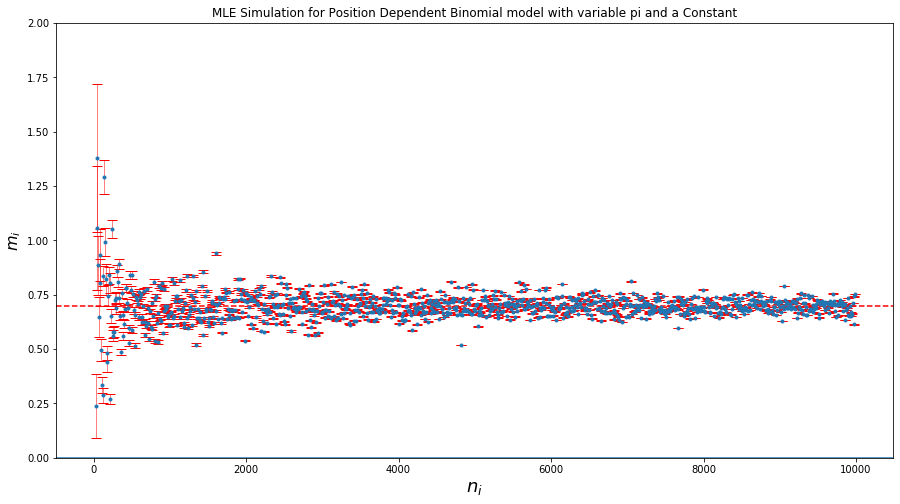

In [9]:
t = time.time()
# Plotting the simulation per coverage size:
est_list = []
sd_list = []
rng = range(10,max_n_i,10)
for i in rng:
    pi_i = np.random.gamma(shape, scale, i)
    pi_i_zero = np.random.gamma(shape_zero, scale_Zero, i)
    tmp = pi_i_zero+pi_i*m_i
    tmp[tmp>0.8]=0.8
    t_i = np.random.binomial(1,tmp)
    solution = fsolve(FOC_zero, m_i_initial_guess,args=(i,pi_i,pi_i_zero))[0]
    #solution = sp.optimize.brentq(FOC,a = 1e-40, b = 1-1e-40,args=(i,pi_i))
    est_list.append(solution)
    sd_list.append(1/(-SOC_zero(solution,i,pi_i,pi_i_zero)))
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
#ax.plot(list(rng),est_list,lw = 1)
ax.errorbar(list(rng), est_list, sd_list, linestyle='', marker='.',capsize=5,ecolor = 'red',elinewidth = 0.5,capthick = 1,lw=1)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Position Dependent Binomial model with variable pi and a Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
ax.axhline()
plt.show()

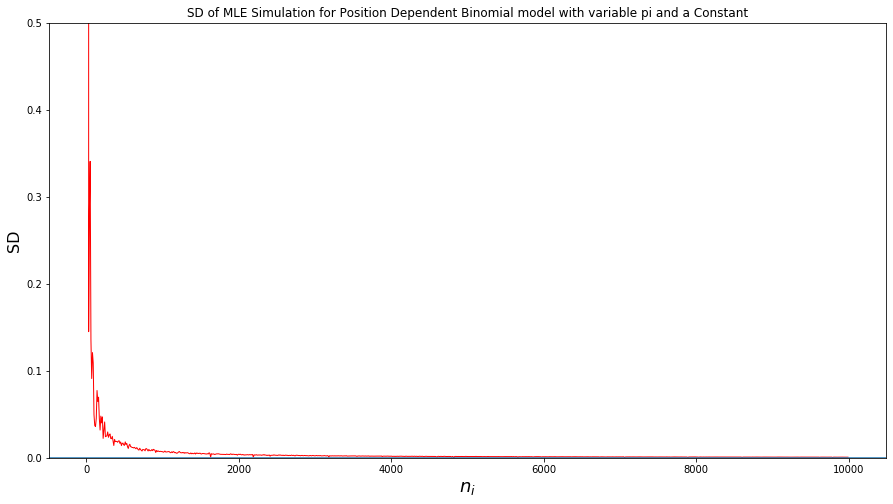

In [10]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),sd_list,lw=1,color='red')
ax.set_title('SD of MLE Simulation for Position Dependent Binomial model with variable pi and a Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('SD', fontsize=16)
plt.ylim([0,0.5])
ax.axhline()
plt.show()


Elapsed (seconds): 11.38


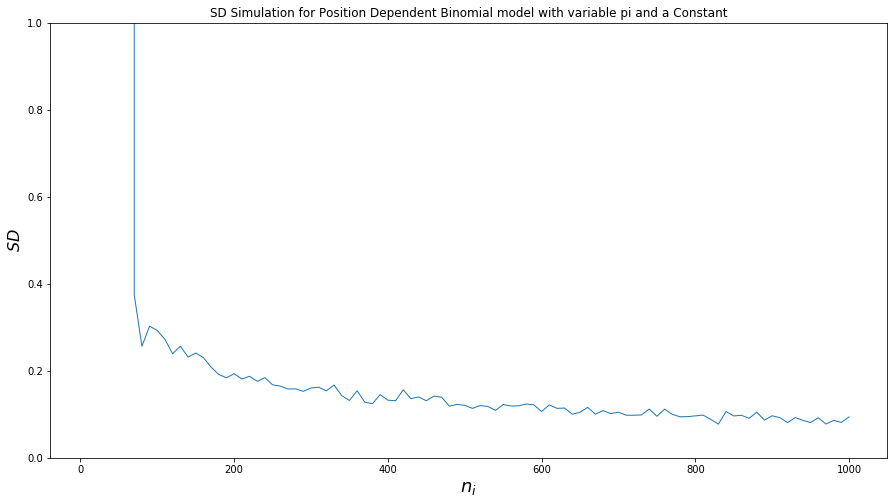

In [11]:
t = time.time()
# Plotting the simulation per coverage size:
max_n_i = 1000 # number of coverage per read
sims = 100
sd_emp_list = []
rng = range(10,max_n_i+10,10)
for i in rng:
    est_list =[]
    for k in range(1,sims+1):
        pi_i = np.random.gamma(shape, scale, i)
        pi_i_zero = np.random.gamma(shape_zero, scale_Zero, i)
        tmp = pi_i_zero+pi_i*m_i
        tmp[tmp>0.8]=0.8
        t_i = np.random.binomial(1,tmp)
        solution = fsolve(FOC_zero, m_i_initial_guess,args=(i,pi_i,pi_i_zero))[0]
        est_list.append(solution)
    sd_emp_list.append(statistics.stdev(est_list))
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),sd_emp_list,lw = 1)
ax.set_title('SD Simulation for Position Dependent Binomial model with variable pi and a Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$SD$', fontsize=16)
plt.ylim([0,1])
plt.show()